# Tutorial 2: The Cornell Box

**Description:** In this tutorial, we familiarize ourselves a bit more with basic Blender functionality by recreating the Cornell Box. The reflectance and geometric data for the Cornell box scene are available here: https://www.graphics.cornell.edu/online/box/data.html .

**Requirement(s):** import_ipynb

**Author:** Matthew O'Toole

---

In [1]:
import bpy
import bmesh
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb

from t001_hello_world import get_render

# Clear scene
if __name__ == '__main__':
    bpy.ops.wm.read_factory_settings(use_empty=True)

register_class(...):
Info: Registering key-config preferences class: 'Prefs', bl_idname 'Blender' has been registered before, unregistering previous


#### Part 1: Setting up the render engine

In Blender, there are multiple render engines used to convert the 3D scene into 2D images. For computational imaging, it's critical to understand and configure
the appropriate render engine to ensure radiometric accuracy and image fidelity. Blender offers three main render engines, each suited for different use cases depending on performance, realism, and interactivity needs:
* `Cycles`: A physically-based path tracer that supports realistic lighting, reflections, caustics, global illumination, defocus, and motion blur (**high photorealism**).
* `EEVEE`: A real-time rasterization engine that performs simple shading calculations (**limited photorealism**).
* `Workbench`: A render engine optimized for speed that does not perform any shading calculations (**not photorealistic**).

There are other third party renderers available for Blender as well, such as the following:
* `LuxCoreRender` (https://luxcorerender.org/): A versatile physically-based renderer that supports (i) path tracing, (ii) bidirectional path tracing, (iii) photon mapping, (iv) Metropolis light transport, and (v) spectral rendering (among many other features).

There are also Blender add-ons for exporting scenes into formats compatible with other notable renderers, including Mitsuba (https://github.com/mitsuba-renderer/mitsuba-blender) and PBRT (https://www.pbrt.org/resources).

This tutorial relies on `Cycles`, a capable and well-supported renderer.

In [2]:
if __name__ == '__main__':
    # Set render engine and resolution for ray tracing
    bpy.context.scene.render.engine = 'CYCLES'
    bpy.context.scene.render.resolution_x = 512
    bpy.context.scene.render.resolution_y = 512
    bpy.context.scene.render.image_settings.file_format = 'PNG'

    # Do not reduce number of samples per pixel based on render noise
    bpy.context.scene.cycles.use_adaptive_sampling = False 

    # Set number of samples to render at each pixel
    bpy.context.scene.cycles.samples = 100

    # Do not denoise the rendered image
    bpy.context.scene.cycles.use_denoising = False


#### Part 2: Defining the materials

Next, we will define the materials (i.e. reflectance functions) used by all the objects within the Cornell Box scene.  This includes three Lambertian materials and an area light source.

To do this, we use Blender's Principled BSDF (bidirectional scattering distribution function).  Creating a perfectly Lambertian surface requires setting the Roughness value to 1.

In [3]:
if __name__ == '__main__':
    emissive_material = bpy.data.materials.new(name='Emissive Material')
    emissive_material.use_nodes = True
    bsdf = emissive_material.node_tree.nodes['Principled BSDF']
    bsdf.inputs['Emission Strength'].default_value = 50
    bsdf.inputs['Roughness'].default_value = 1

    white_material = bpy.data.materials.new(name='White Material')
    white_material.use_nodes = True
    bsdf = white_material.node_tree.nodes['Principled BSDF']
    bsdf.inputs['Base Color'].default_value = (1, 1, 1, 1)
    bsdf.inputs['Roughness'].default_value = 1

    red_material = bpy.data.materials.new(name='Red Material')
    red_material.use_nodes = True
    bsdf = red_material.node_tree.nodes['Principled BSDF']
    bsdf.inputs['Base Color'].default_value = (1, 0, 0, 1)
    bsdf.inputs['Roughness'].default_value = 1

    green_material = bpy.data.materials.new(name='Green Material')
    green_material.use_nodes = True
    bsdf = green_material.node_tree.nodes['Principled BSDF']
    bsdf.inputs['Base Color'].default_value = (0, 1, 0, 1)
    bsdf.inputs['Roughness'].default_value = 1

#### Part 3: Defining the geometry

The scene geometry consists of a set of objects, each one defined by an array of quads. The following arrays contain the position of 4N vertices to define N quads.

In [4]:
if __name__ == '__main__':
    floor = [
        (552.8, 0.0,   0.0),
        (  0.0, 0.0,   0.0),
        (  0.0, 0.0, 559.2),
        (549.6, 0.0, 559.2),
    ]

    # Define a small offset for the lights so that it is just below the ceiling.
    epsilon = -0.001

    light = [
        (343.0, 548.8 + epsilon, 227.0), 
        (343.0, 548.8 + epsilon, 332.0),
        (213.0, 548.8 + epsilon, 332.0),
        (213.0, 548.8 + epsilon, 227.0),
    ]

    ceiling = [
        (556.0, 548.8,   0.0),
        (556.0, 548.8, 559.2),
        (  0.0, 548.8, 559.2),
        (  0.0, 548.8,   0.0),
    ]

    back_wall = [
        (549.6,   0.0, 559.2),
        (  0.0,   0.0, 559.2),
        (  0.0, 548.8, 559.2),
        (556.0, 548.8, 559.2),
    ]

    right_wall = [
        (0.0,   0.0, 559.2), 
        (0.0,   0.0,   0.0),
        (0.0, 548.8,   0.0),
        (0.0, 548.8, 559.2),
    ]

    left_wall = [
        (552.8,   0.0,   0.0),
        (549.6,   0.0, 559.2),
        (556.0, 548.8, 559.2),
        (556.0, 548.8,   0.0),
    ]

    short_block = [
        (130.0, 165.0,  65.0),
        ( 82.0, 165.0, 225.0),
        (240.0, 165.0, 272.0),
        (290.0, 165.0, 114.0),

        (290.0,   0.0, 114.0),
        (290.0, 165.0, 114.0),
        (240.0, 165.0, 272.0),
        (240.0,   0.0, 272.0),

        (130.0,   0.0,  65.0),
        (130.0, 165.0,  65.0),
        (290.0, 165.0, 114.0),
        (290.0,   0.0, 114.0),

        ( 82.0,   0.0, 225.0),
        ( 82.0, 165.0, 225.0),
        (130.0, 165.0,  65.0),
        (130.0,   0.0,  65.0),

        (240.0,   0.0, 272.0),
        (240.0, 165.0, 272.0),
        ( 82.0, 165.0, 225.0),
        ( 82.0,   0.0, 225.0),
    ]

    tall_block = [
        (423.0, 330.0, 247.0),
        (265.0, 330.0, 296.0),
        (314.0, 330.0, 456.0),
        (472.0, 330.0, 406.0),

        (423.0,   0.0, 247.0),
        (423.0, 330.0, 247.0),
        (472.0, 330.0, 406.0),
        (472.0,   0.0, 406.0),

        (472.0,   0.0, 406.0),
        (472.0, 330.0, 406.0),
        (314.0, 330.0, 456.0),
        (314.0,   0.0, 456.0),

        (314.0,   0.0, 456.0),
        (314.0, 330.0, 456.0),
        (265.0, 330.0, 296.0),
        (265.0,   0.0, 296.0),

        (265.0,   0.0, 296.0),
        (265.0, 330.0, 296.0),
        (423.0, 330.0, 247.0),
        (423.0,   0.0, 247.0),
    ]

#### Part 4: Converting vertex data to objects

Given the materials and geometry data, it is now time to assemble the set of objects that make up the Cornell Box scene.  For each object, we define (i) the vertices, (ii) faces made from vertices, (iii) the material used by the object, and (iv) the parent object.

Note: All child objects inherit the transformations from its parent object (e.g., 'Cornell Box'). For example, we scale all objects within the scene by adjusting the scale of the parent object.

In [5]:
def create_object(name, vertices, material, parent_obj=None):
    mesh = bpy.data.meshes.new(name)
    bm = bmesh.new()

    for vertex in vertices:
        bm.verts.new(vertex)

    bm.verts.ensure_lookup_table()

    for k in range(0, len(vertices), 4):
        bm.faces.new((bm.verts[k+0], 
                      bm.verts[k+1], 
                      bm.verts[k+2], 
                      bm.verts[k+3]))

    bm.to_mesh(mesh)
    bm.free()

    obj = bpy.data.objects.new(name, mesh)
    bpy.context.collection.objects.link(obj)
    obj.parent = parent_obj
    obj.data.materials.append(material)

    return

if __name__ == '__main__':
    parent_obj = bpy.data.objects.new('Cornell Box', None)
    bpy.context.collection.objects.link(parent_obj)

    create_object('floor',       floor,       white_material,    parent_obj)
    create_object('light',       light,       emissive_material, parent_obj)
    create_object('ceiling',     ceiling,     white_material,    parent_obj)
    create_object('back_wall',   back_wall,   white_material,    parent_obj)
    create_object('right_wall',  right_wall,  green_material,    parent_obj)
    create_object('left_wall',   left_wall,   red_material,      parent_obj)
    create_object('short_block', short_block, white_material,    parent_obj)
    create_object('tall_block',  tall_block,  white_material,    parent_obj)

    # Rescale the scene to a reasonable size
    parent_obj.scale = (0.01, 0.01, 0.01)

#### Part 4: Defining the camera

Finally, to create the camera, we take an alternative approach than the one show in the previous tutorial.  We explicitly create a new camera data-block, link it to an object, and assign the object to the scene.

In [6]:
if __name__ == '__main__':
    camera_data = bpy.data.cameras.new(name='Camera')
    camera_object = bpy.data.objects.new('Camera', camera_data)
    bpy.context.scene.collection.objects.link(camera_object)
    bpy.context.scene.camera = camera_object

    camera_data.sensor_width = 25
    camera_data.sensor_height = 25
    camera_data.lens = 35

    camera_object.location = (2.78, 2.73, -8.00)
    camera_object.rotation_euler = (0, np.pi, 0)

#### Part 5: Rendering our result and saving the scene

Using functionality defined in the previous tutorial, we render out the scene.  We also save the scene, as it will come in handy in future tutorials.

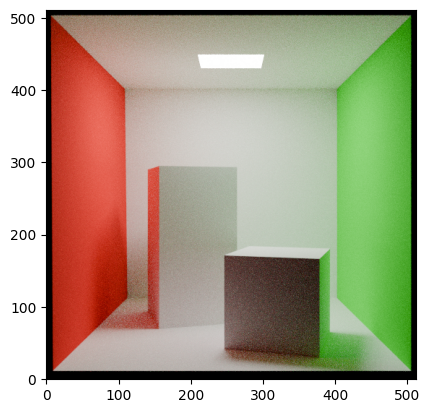

In [7]:
if __name__ == '__main__':
    plt.imshow(get_render(), origin='lower')

    path = "./scenes/cornell_box.ipynb"
    bpy.ops.wm.save_as_mainfile(filepath=path)
